# Modelos Lineales Generalizados (GML)

## Regresión Lineal Gaussiana

In [1]:
import geopandas as gpd
import numpy as np
import matplotlib.pyplot as plt
import statsmodels.api as sm
from sklearn.preprocessing import StandardScaler

In [2]:
gdf = gpd.read_file("https://github.com/algarciach/AnalisisGeoespacial/raw/main/Covid19_model/Data/covid19_municipios_antioquia.gpkg")
gdf.info()

In [ ]:
gdf["y_log"] = np.log(gdf["cfr"] + 1)
var = ['area_municipio', 'altitud', 'temperatura', 'humedad_relativa', 'densidad']

st = StandardScaler()
X_scaled = st.fit_transform(gdf[var])

X = sm.add_constant(X_scaled)
y = gdf["y_log"]

model = sm.OLS(y, X).fit()
print(model.summary())

```text
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                  y_log   R-squared:                       0.199
Model:                            OLS   Adj. R-squared:                  0.165
Method:                 Least Squares   F-statistic:                     5.903
Date:                Wed, 25 Jun 2025   Prob (F-statistic):           6.55e-05
Time:                        00:16:58   Log-Likelihood:                -33.541
No. Observations:                 125   AIC:                             79.08
Df Residuals:                     119   BIC:                             96.05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.3239      0.029     45.639      0.000       1.266       1.381
x1            -0.0195      0.036     -0.543      0.588      -0.091       0.052
x2            -0.2757      0.213     -1.292      0.199      -0.698       0.147
x3            -0.1397      0.212     -0.660      0.511      -0.559       0.280
x4            -0.0461      0.034     -1.365      0.175      -0.113       0.021
x5            -0.0492      0.030     -1.624      0.107      -0.109       0.011
==============================================================================
Omnibus:                        1.859   Durbin-Watson:                   1.765
Prob(Omnibus):                  0.395   Jarque-Bera (JB):                1.486
Skew:                          -0.040   Prob(JB):                        0.476
Kurtosis:                       3.528   Cond. No.                         16.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
```

**Conclusiones** El modelo de regresión gaussiano OLS es estadísticamente significativo en su conjunto, lo que significa que las variables independientes combinadas tienen un efecto sobre la variable dependiente. Sin embargo, el poder explicativo del modelo es bajo (R-squared), lo que sugiere que hay mucha variabilidad en la variable dependiente que no está siendo capturada por este conjunto de predictores.

Lo más notable es que, ninguna de las variables independientes individuales (x1 a x5) es estadísticamente significativa. Esto implica que, aunque el modelo como un todo es "útil", no se puede concluir con confianza que alguna de las variables incluidas individualmente tenga un impacto significativo en la variable dependiente.

Los diagnósticos del modelo (normalidad de residuos, ausencia de autocorrelación y baja multicolinealidad) son generalmente buenos, lo que indica que los supuestos del OLS se cumplen razonablemente bien.

In [5]:
# Obtener las predicciones
y_pred = model.predict(X)
gdf["y_pred"] = y_pred

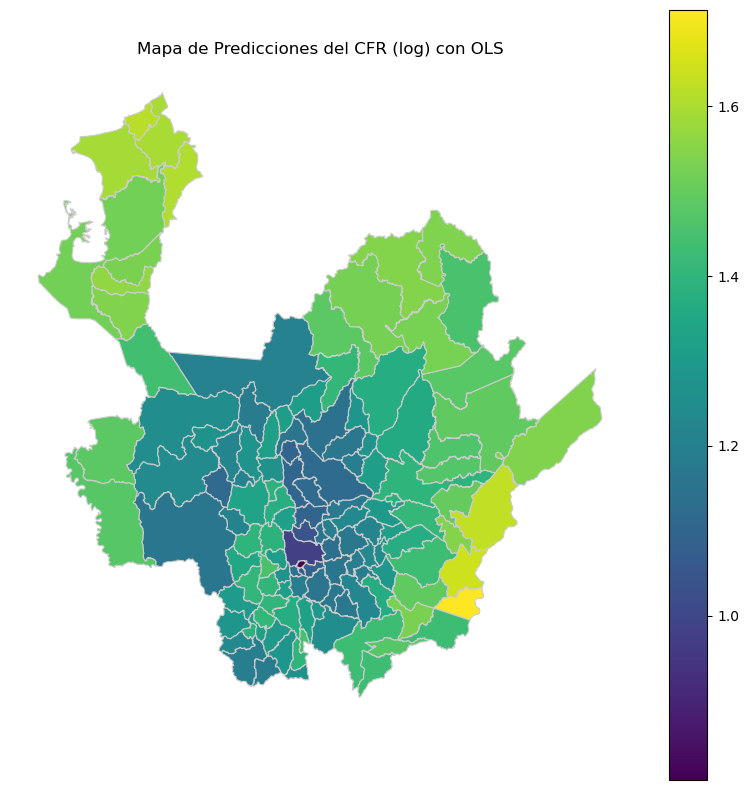

In [6]:
fig, ax = plt.subplots(1,1, figsize=(10, 10))
gdf.plot(column="y_pred", cmap="viridis", legend=True, ax=ax, linewidth=0.8, edgecolor="0.8")
ax.set_title("Mapa de Predicciones del CFR (log) con OLS")
ax.set_axis_off()
plt.show()

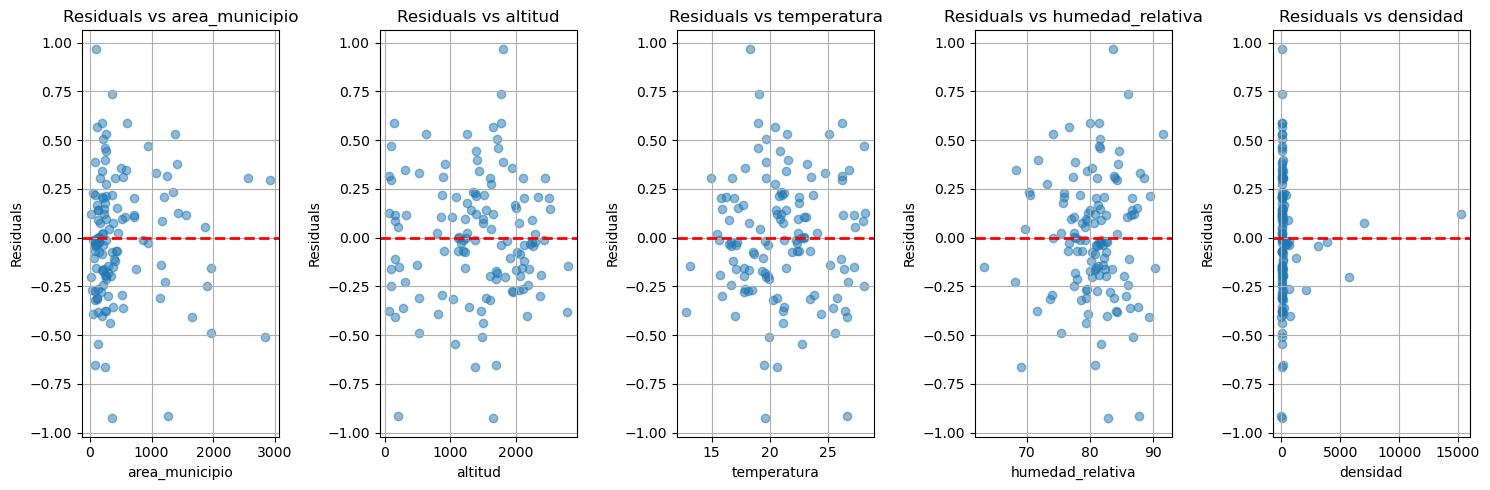

In [7]:
# Calculate the residuals
residuals = y - y_pred

# Create figure for residuals
plt.figure(figsize=(15, 5))

for i, variable in enumerate(var):
    plt.subplot(1, len(var), i + 1)
    plt.scatter(gdf[variable], residuals, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--', lw=2)
    plt.title(f'Residuals vs {variable}')
    plt.xlabel(variable)
    plt.ylabel('Residuals')
    plt.grid(True)
    
plt.tight_layout()
plt.show()

## Regresión Logística

In [8]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
gdf['evento_cfr'] = np.where(gdf['cfr'] > 3, 1, 0)

var = ['area_municipio', 'altitud', 'temperatura', 'humedad_relativa', 'densidad']
y = gdf['evento_cfr']

st = StandardScaler()
X_scaled = st.fit_transform(gdf[var])
X = sm.add_constant(X_scaled)

model = sm.Logit(y, X).fit()
print(model.summary())

```text
Optimization terminated successfully.
         Current function value: 0.573381
         Iterations 10
                           Logit Regression Results                           
==============================================================================
Dep. Variable:             evento_cfr   No. Observations:                  125
Model:                          Logit   Df Residuals:                      119
Method:                           MLE   Df Model:                            5
Date:                Wed, 25 Jun 2025   Pseudo R-squ.:                  0.1697
Time:                        00:52:59   Log-Likelihood:                -71.673
converged:                       True   LL-Null:                       -86.319
Covariance Type:            nonrobust   LLR p-value:                 2.031e-05
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -1.0279      0.703     -1.463      0.144      -2.405       0.349
x1            -0.1267      0.247     -0.513      0.608      -0.611       0.357
x2            -0.8821      1.516     -0.582      0.561      -3.853       2.089
x3            -0.1838      1.501     -0.122      0.903      -3.127       2.759
x4            -0.2996      0.236     -1.267      0.205      -0.763       0.164
x5            -5.0230      3.436     -1.462      0.144     -11.757       1.711
==============================================================================
```


In [10]:
y_prob = model.predict(X)

gdf['probability_eventCFR'] = y_prob


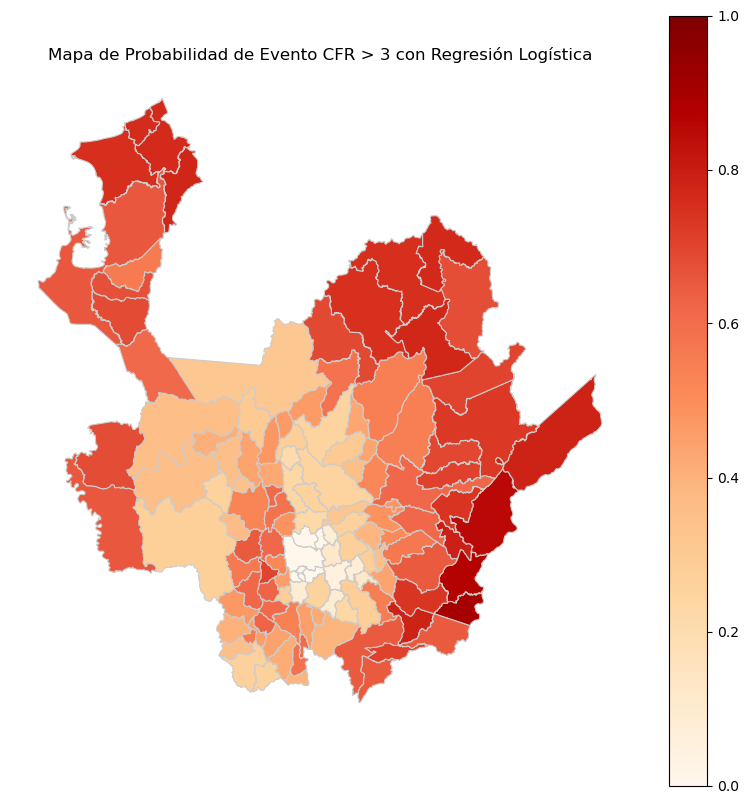

In [11]:
# Plot map with probabilities predicted by the logistic regression
fig, ax = plt.subplots(1, 1, figsize=(10, 10))
gdf.plot(column='probability_eventCFR', cmap='OrRd', legend=True, ax=ax, linewidth=0.8, edgecolor='0.8', vmin=0, vmax=1)
ax.set_title('Mapa de Probabilidad de Evento CFR > 3 con Regresión Logística')
ax.set_axis_off()
plt.show()

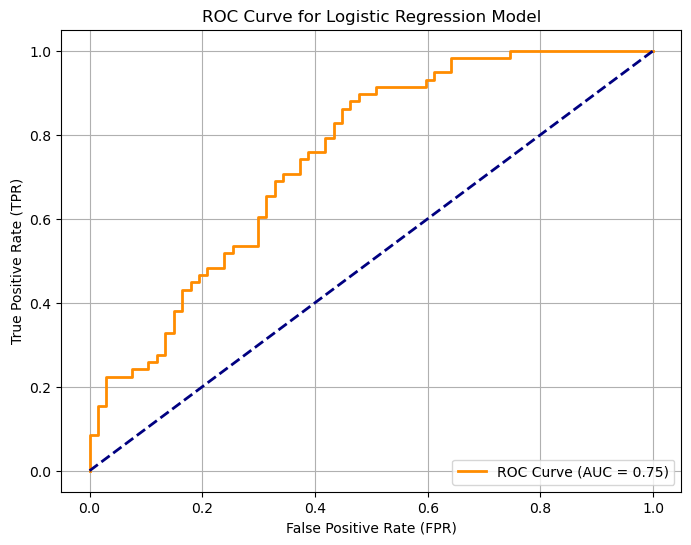

In [12]:
# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y, y_prob)
auc = roc_auc_score(y, y_prob)

# Plot ROC curve
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate (FPR)')
plt.ylabel('True Positive Rate (TPR)')
plt.title('ROC Curve for Logistic Regression Model')
plt.legend(loc='lower right')
plt.grid()
plt.show()

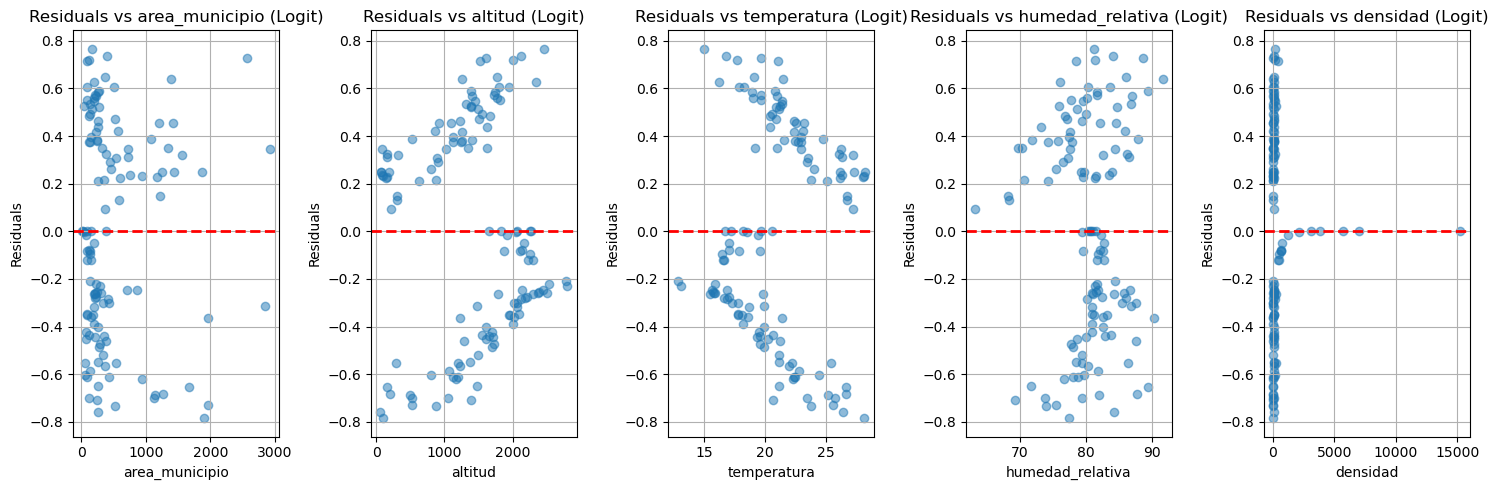

In [13]:
# Calculate the residuals for the logistic regression model
residuals_logit = y - y_prob
# Create figure for residuals of logistic regression
plt.figure(figsize=(15, 5))
for i, variable in enumerate(var):
    plt.subplot(1, len(var), i + 1)
    plt.scatter(gdf[variable], residuals_logit, alpha=0.5)
    plt.axhline(0, color='red', linestyle='--', lw=2)
    plt.title(f'Residuals vs {variable} (Logit)')
    plt.xlabel(variable)
    plt.ylabel('Residuals')
    plt.grid(True)
plt.tight_layout()
plt.show()

## Regresión de Poisson

## Regresión Binomial Negativa

## Modelo de Ceros Inflados de Poisson